In [1]:
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.ticker as tick
import seaborn as sns
import tensorflow as tf
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import scipy.stats as stat
import scipy.optimize as opt
import scipy.ndimage as img
import numpy.linalg as la
import numpy.random as rd
import cvxpy as cvx
from sklearn.metrics import mean_squared_error as mse
import time, warnings
import datetime as date
from itertools import permutations
from lbfgs import fmin_lbfgs
from tqdm.notebook import trange, tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
sns.set()
sns.set_context('notebook')
mp.rcParams["figure.figsize"] = (5*16/9 ,5)
mp.rcParams["figure.dpi"] = 100

In [3]:
def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def cossim(x, xhat):
    A = x/x.max()
    B = xhat/xhat.max()
    assert len(A) == len(B), "Data coefficients and recovered coefficients are not of equal length"
    num = 0
    for i in range(len(A)):
        num += A[i]*B[i]
    den = la.norm(A, ord=2) * la.norm(B, ord=2)
    return num/den

In [4]:
def f(t, C, v, d):
    if isinstance(C, list) or isinstance(C, np.ndarray):
        y = np.zeros_like(t)
        for k in range(len(C)):
            y += C[k]*np.sin(2*np.pi*v[k]*t + d[k])
        return y
    else:
        y = C*np.sin(2*np.pi*v*t + d)
        return y

In [5]:
rd.seed(402)
N = 1000
Ts = 1
t = np.arange(0, N, Ts, "float64")
C = [1, 2.5, 1]
w = np.array([0.025, 0.03, 0.035])/2/np.pi
d = [0, 0, 0]
x = f(t, C, w, d)
M = 50
xi = np.sort(rd.choice(N, M, replace=False))
tx = t[xi]
y = x[xi]

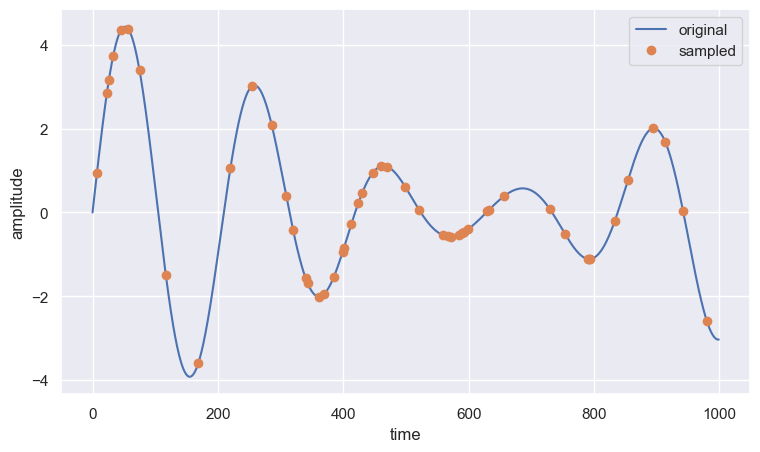

In [6]:
mp.plot(t, x, "-", label="original")
mp.plot(tx, y, "o", label="sampled")
mp.xlabel("time")
mp.ylabel("amplitude")
mp.legend()
mp.show()

In [7]:
def yhatm(xi, w):
    assert len(w)%3 == 0, "Parameter vector cannot be broadcast over evaluating function; check if len(parameters) is an integer multiple of 3."
    comp_dim = len(w)//3
    C, v, d = w[:comp_dim], w[comp_dim:2*comp_dim], w[2*comp_dim:]
    y = np.zeros_like(xi, float)
    for m in range(len(xi)):
        for i in range(len(C)):
            y[m] += C[i]*np.sin(v[i]*xi[m]*Ts + d[i])
    return y

def objerr(y, yhat):
#     assert y.shape == yhat.shape, "Signals are not of equal shape."
    res = yhat - y
    Of = np.sum((res)**2)
    return Of

class Bounds:
    def __init__(self, lb, ub):
        self.lb = lb
        self.ub = ub
        self.diff = np.fabs(lb - ub)

In [8]:
gen_max = 100
NP = 100 # population of each parameter
P = 3 # how many parameters
CR = 0.9
F = 0.8
k_bounds = Bounds(1, 5)
C_bounds = Bounds(-3, 3)
v_bounds = Bounds(0.01, 0.06)
d_bounds = Bounds(0, np.pi)

In [29]:
for count in trange(gen_max, desc='generation'):
    for kh in [3]:
        pop = rd.random((NP, kh*P))
        pop_denorm = np.zeros_like(pop)
        pop_denorm.T[:kh] = C_bounds.lb + pop.T[:kh]*C_bounds.diff
        pop_denorm.T[kh:2*kh] = v_bounds.lb + pop.T[kh:2*kh]*v_bounds.diff
        pop_denorm.T[2*kh:3*kh] = d_bounds.lb + pop.T[2*kh:3*kh]*d_bounds.diff
        eval_init = np.asarray([yhatm(xi, ind) for ind in pop_denorm])
        cost = np.asarray([objerr(y, eval_init) for ind in eval_init])
        best_idx = np.argmin(cost)
        best = pop_denorm[best_idx]
        D = len(pop.T)
        for i in trange(NP, desc='sample', leave=False):

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'assign'